Census Income Project
Problem Statement:


This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [5]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")

In [7]:
df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [8]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

Ensuring that in future observationswe dont have any truncated information being displayed in our jupter notebook.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Using the info method we can see that there are 6 columns with integer datatype and 9 columns that have object data type.We will try to separate these columnsfor easier analysis purpose. 

In [10]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [11]:
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are: ",object_datatype) 


integer_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'int64':
        integer_datatype.append(x)
print(f"\nInteger Data Type Columns are: ",integer_datatype)

Object Data Type Columns are:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Integer Data Type Columns are:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


We have successful bifurcated the object datatype column names and integer data type columns name.Since we dont have to worry 
about outliers and skewness in categorical columns we can use this separatedcolumn names to pre process only on numerical continuos columns.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
Fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
Education_num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
Capital_gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
Capital_loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
Hours_per_week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


Using the describe method we can take a look at the numerical data type columns and observe the distribution of integer data amongst them.

In [13]:
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

It looks like we do not have any missing data present in our dataset for any of the columns.

<AxesSubplot:>

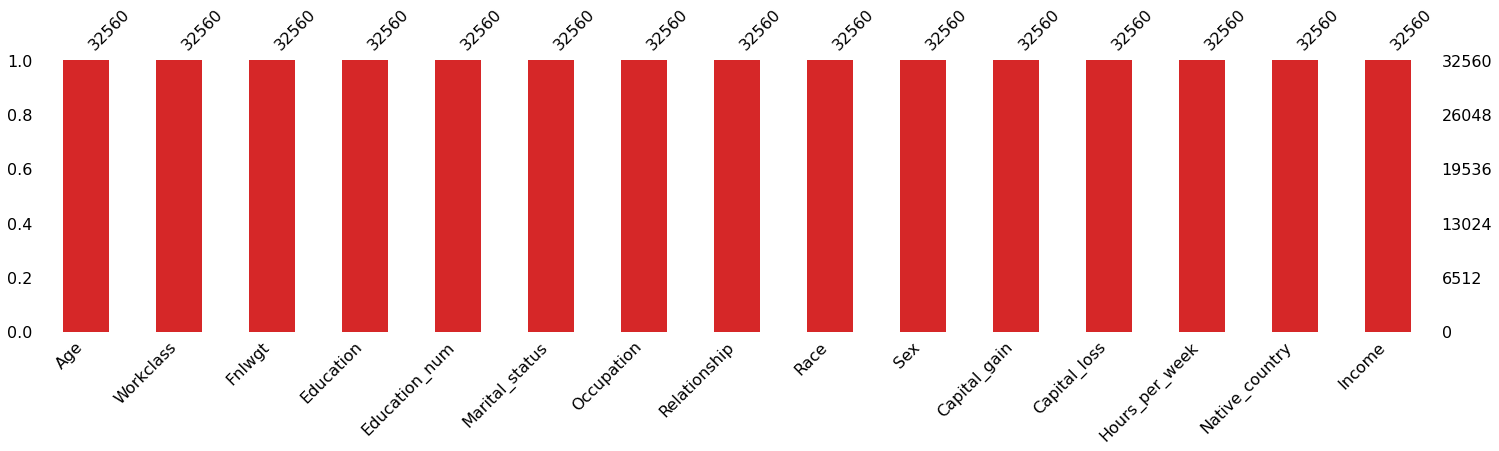

In [14]:
missingno.bar(df, figsize=(25,5), color="tab:red")

we are able to depict the missing valuesinformation in a bar plot format where we can clearly see that all the rows filled with data there are no null values present.

In [15]:
print(f"Rows and Columns before dropping duplicates:",df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates:",df.shape)

Rows and Columns before dropping duplicates: (32560, 15)
Rows and Columns after dropping duplicates: (32536, 15)


Drop 

In [16]:
df.nunique().to_frame("Unique Values")

,Unique Values
Age,73
Workclass,9
Fnlwgt,21647
Education,16
Education_num,16
Marital_status,7
Occupation,15
Relationship,6
Race,5
Sex,2


The nunique method lists down the number of all the unique data present in each column of our dataset.

In [17]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*120)

Workclass
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
Education
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
Marital_status
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64
Occupation
 Prof-specialty       41

In the above cell we are taking a look at all the unique values of object data type column. 

In [18]:
df['Workclass'].replace({'?':'Other_Working_Class'},inplace=True)
df['Occupation'].replace({'?':'Other_Occupation'},inplace=True)
df['Native_country'].replace({'?':'Others'},inplace=True)

We have successfully replace all the data.

Visualization

In [19]:
print(f"Object Data Type Columns Names:",object_datatype)
print(f"\nInteger Data Type Columns Names:",integer_datatype)

Object Data Type Columns Names: ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Integer Data Type Columns Names: ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


listing out the columns names.

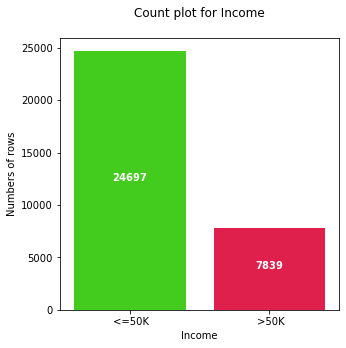

In [20]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Income'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that our target label "income" column has imbalanced dataset that will need to be taken care of before we start building classification machine learning model.

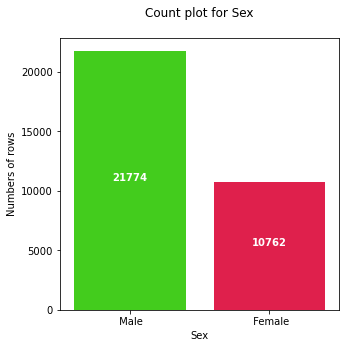

In [21]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Sex'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that the number of data values for male is higher than that of its female counterparts.

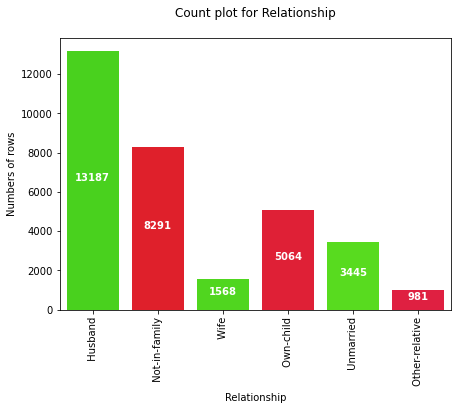

In [22]:
try:
    plt.figure(figsize=(7,5))
    col_name = 'Relationship'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that the relationship status the values for husband is the highest and other realtive has the lowest data.

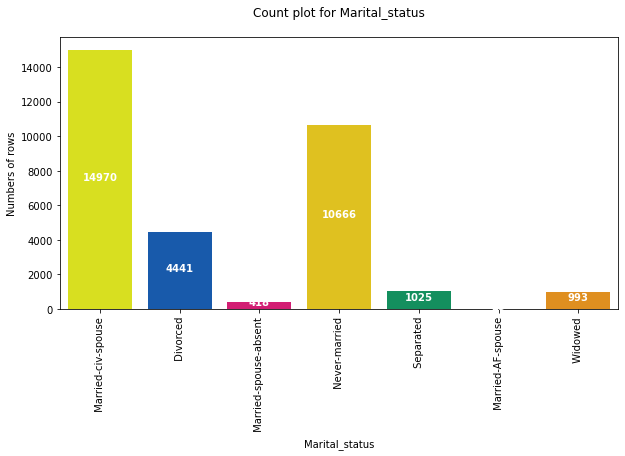

In [23]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Marital_status'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that the marital status column has married spouse and never married people on the higher edge as compared to the other values.

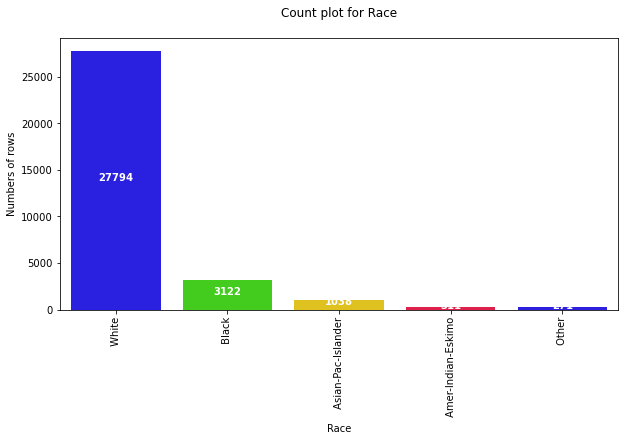

In [24]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Race'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that the Race column mostly comprises of white people in the dataset.

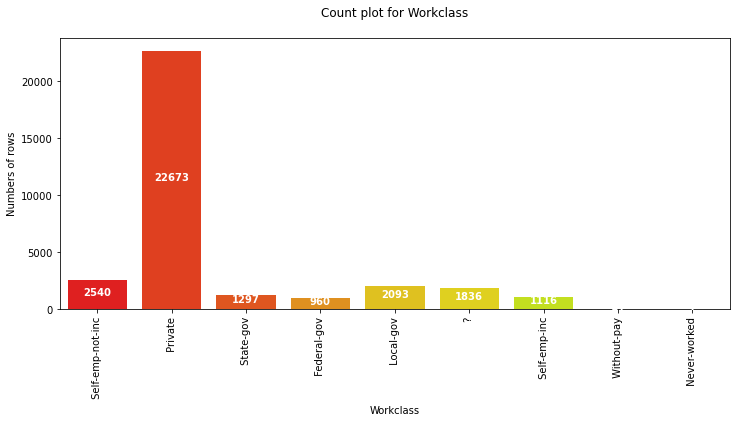

In [25]:
try:
    plt.figure(figsize=(12,5))
    col_name = 'Workclass'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above count plot we can see that the workclass column the highest number of people work for private sector and the other work classes or people who are unemployed is quite less to negligible.

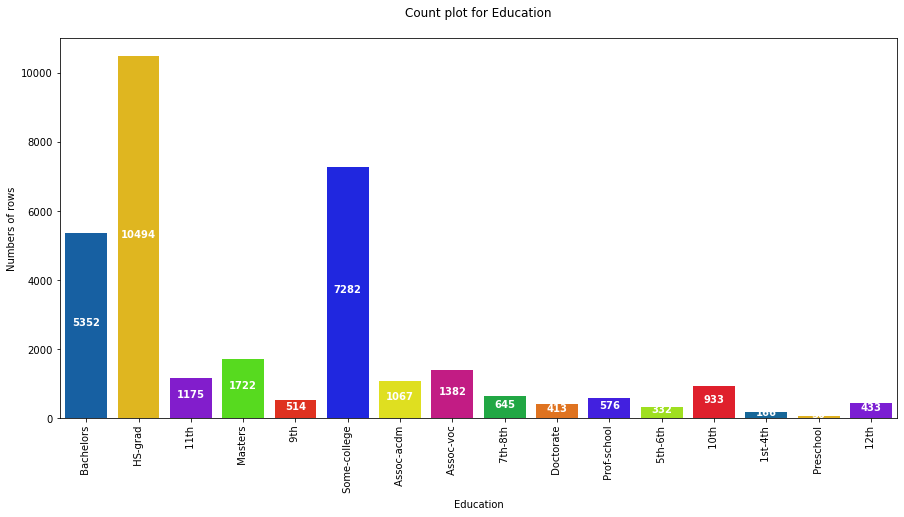

In [26]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Education'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above countplot we can see that education column has the highest numbers of values in HS grad followed by some college and bachelors.

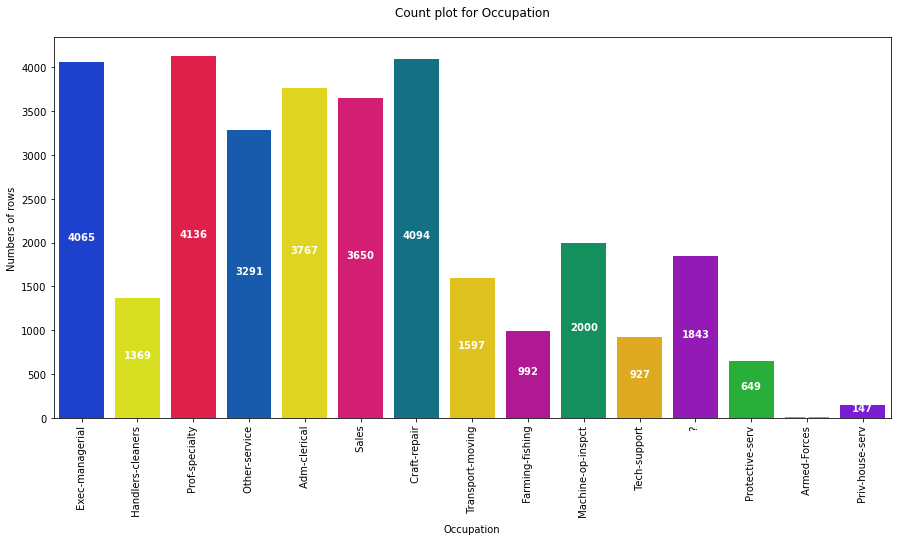

In [27]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Occupation'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above countplot we can see that occupation columnhas various categories out of which people in armed forces are the least and folks engaged in some craft repair , executive manegers and holding some professional speciality are on the rise.

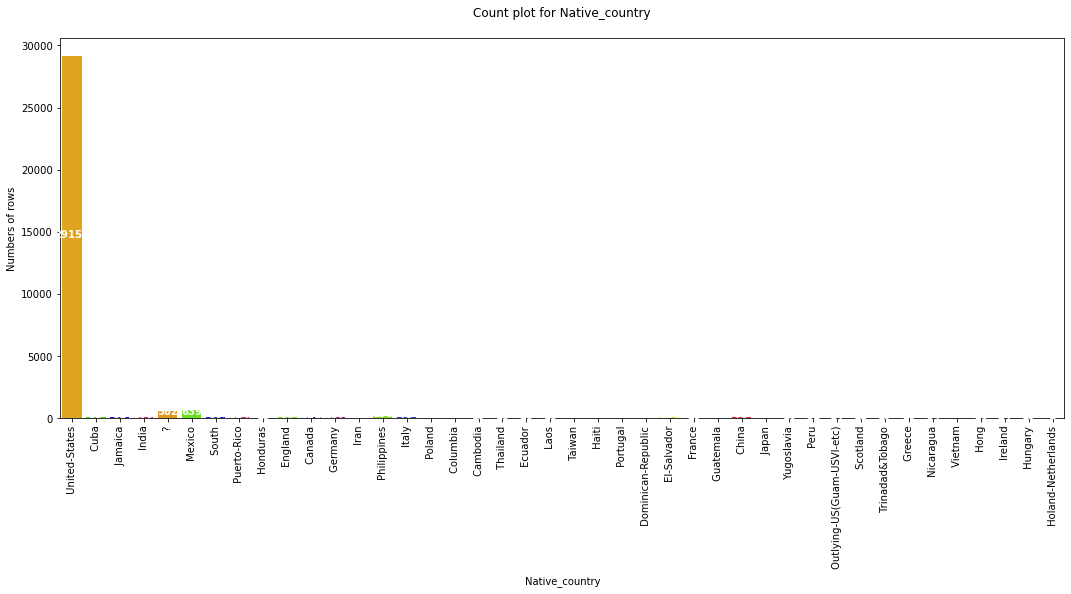

In [28]:
try:
    plt.figure(figsize=(18,7))
    col_name = 'Native_country'
    values = df[col_name].value_counts()
    index = 0 
    ax = sns.countplot(df[col_name],palette="prism")
    
    for i in ax.get_xticklabels():
        ax.text(index,values[i.get_text()]/2,values[i.get_text()],
               horizontalalignment="center",fontweight='bold',color='w')
        index += 1
    plt.title(f"Count plot for {col_name}\n")
    plt.ylabel(f"Numbers of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:",e)
    pass

From the above countplot we can see that the negative country column has the highest value for us followedby mexico and others while the categories has the least to legigible amount of data coverage.

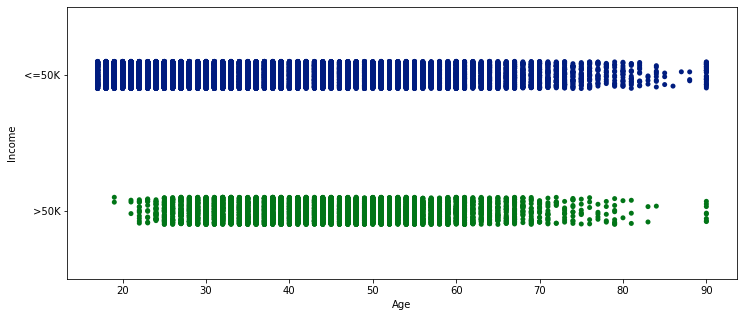

In [29]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(12,5))
sns.stripplot(x = "Age",y = 'Income',data=df)
plt.show()

I n the above strip plot we can see that young people hardly have income more than 50 k.

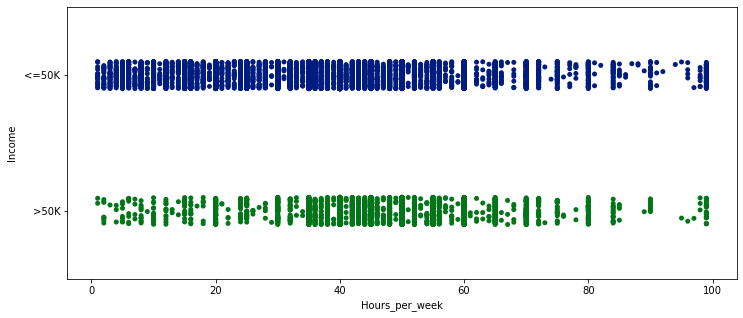

In [30]:
plt.figure(figsize=(12,5))
sns.stripplot(x = "Hours_per_week",y = 'Income',data=df)
plt.show()

In the above strip plot we can see that people who have income less than or equal to 50k put in more hours per week as compared to the ones who earn more than 50k as income.

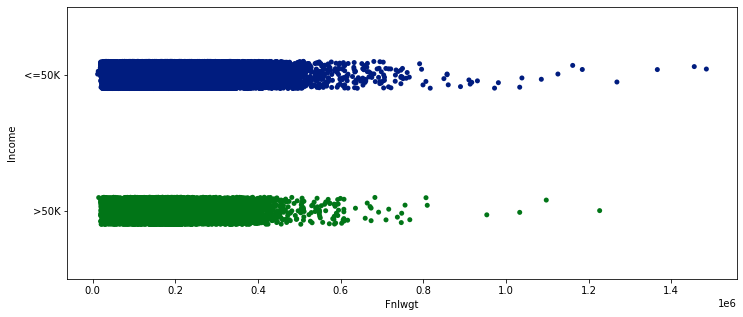

In [31]:
plt.figure(figsize=(12,5))
sns.stripplot(x = "Fnlwgt",y = 'Income',data=df)
plt.show()

In the above strip plot we can see that the final weight has data coverage on a higher scale for people in the <=50k incme bracket as compared to the people in >50k income bracket.

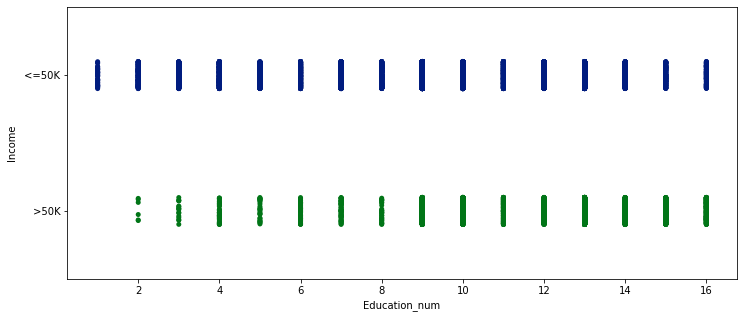

In [32]:
plt.figure(figsize=(12,5))
sns.stripplot(x = "Education_num",y = 'Income',data=df)
plt.show()

In the above strip plot we can see that the the lower education number is almost negligible for people with income >50k and it therefore emphasize on the importance of education too.

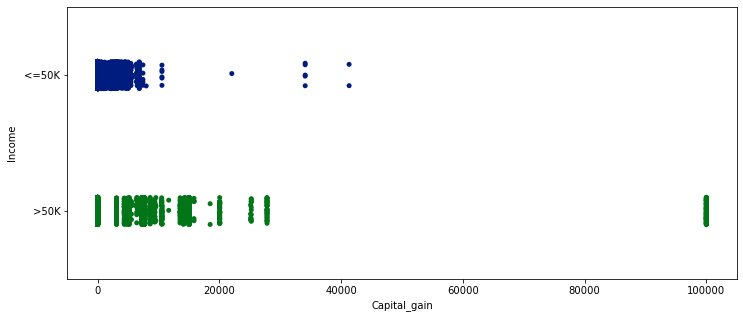

In [33]:
plt.figure(figsize=(12,5))
sns.stripplot(x = "Capital_gain",y = 'Income',data=df)
plt.show()

In the above strip plot we can see that the CAPITAL GAIN IS ON A HIGHER SCALE FOR PEOPLE WITH INCOME >50K.

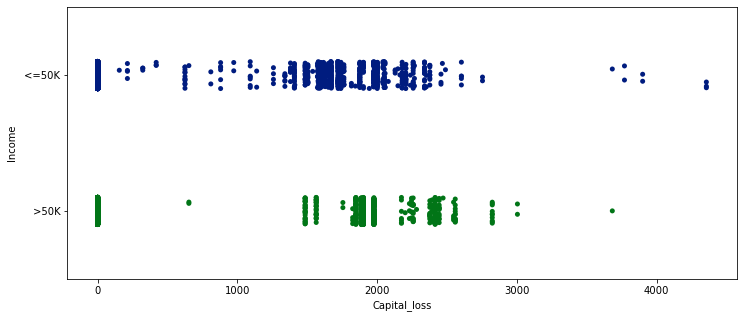

In [34]:
plt.figure(figsize=(12,5))
sns.stripplot(x = "Capital_loss",y = 'Income',data=df)
plt.show()

In the above strip plot we can see that the capital loss for people with income>50k is considerably less than people with income <=50k

Text(0, 0.5, 'Percentage of People')

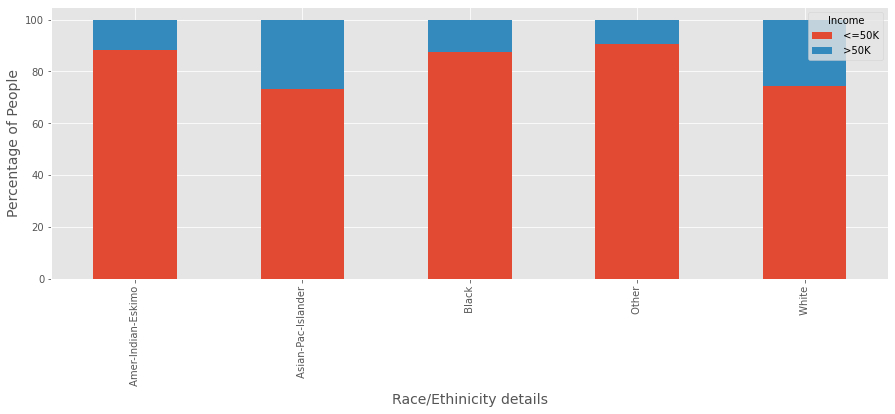

In [35]:
plt.style.use('ggplot')
tbl = pd.crosstab(df['Race'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Race/Ethinicity details',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)  

The above cross tab bar plot show us different ethenicity race group folks and the income variation between them.

Text(0, 0.5, 'Percentage of People')

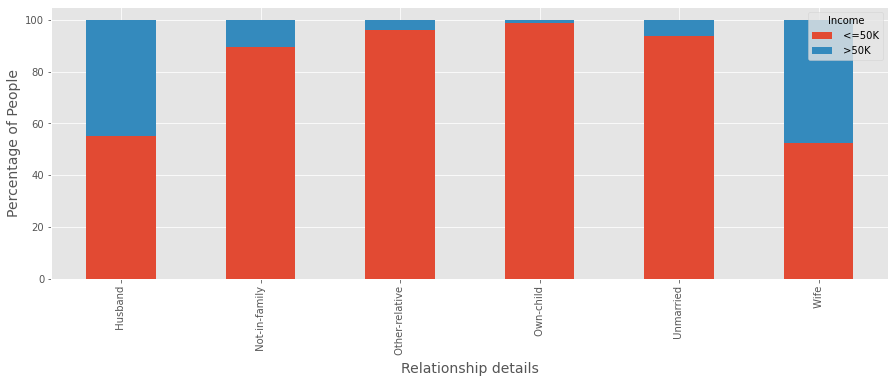

In [36]:
tbl = pd.crosstab(df['Relationship'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Relationship details',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us difference in income details for people in different relationship status.people who are earning >50k are mostly from the relationship status from husband or wife.

Text(0, 0.5, 'Percentage of People')

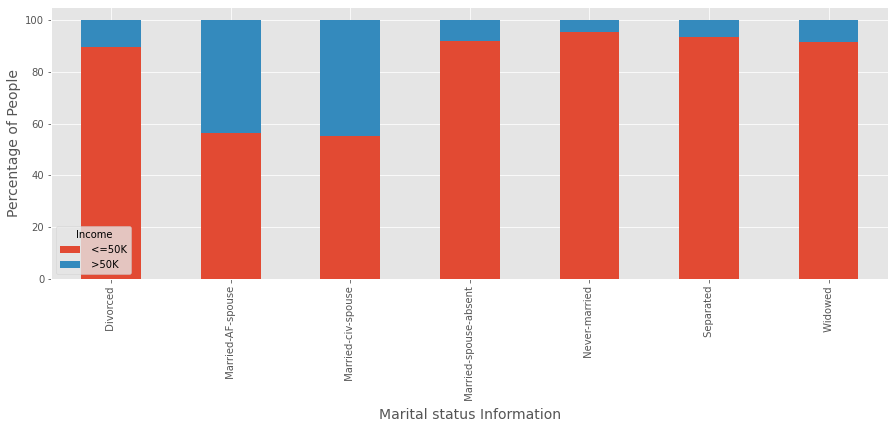

In [37]:
tbl = pd.crosstab(df['Marital_status'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Marital status Information',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us the marrital status  of people who have income either <=50k or >=50k. 

Text(0, 0.5, 'Percentage of People')

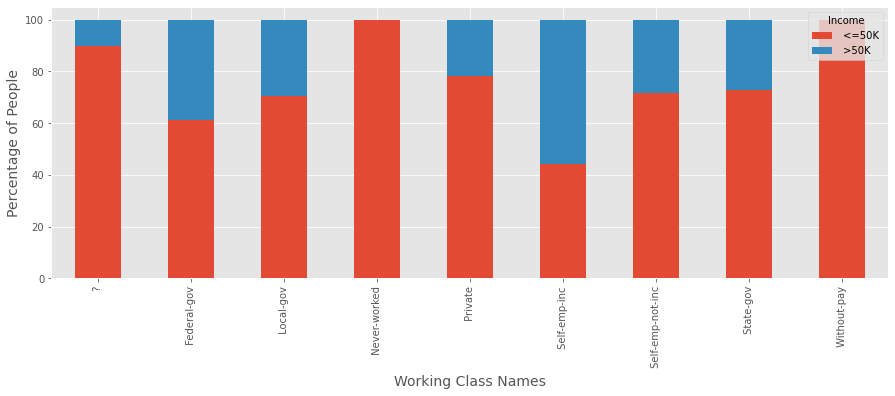

In [38]:
tbl = pd.crosstab(df['Workclass'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Working Class Names',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us the working class information .

Text(0, 0.5, 'Percentage of People')

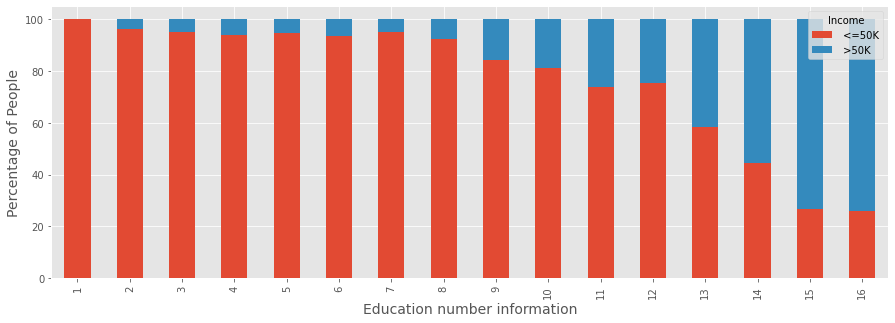

In [39]:
tbl = pd.crosstab(df['Education_num'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education number information',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us the education number scale which indicated that to earn an income of >50k you need to have a higher educational number emphasizing the importance on the educational front.

Text(0, 0.5, 'Percentage of People')

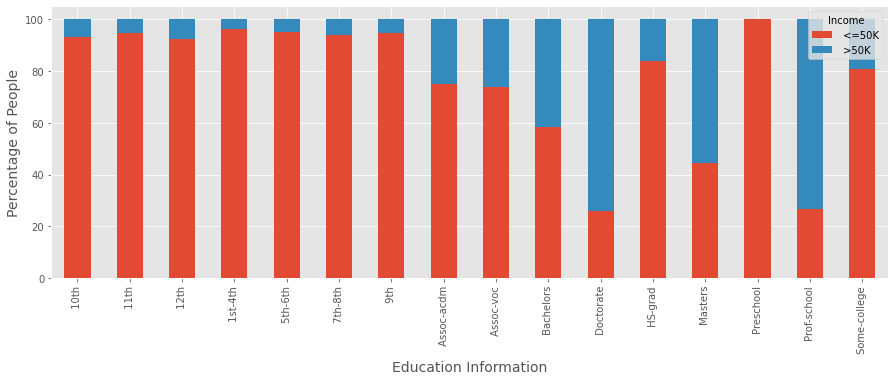

In [40]:
tbl = pd.crosstab(df['Education'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education Information',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us different education types for people and their income scale. it looks like people with >50k income have a qualification in doctorate, masters and professional school .

Text(0, 0.5, 'Percentage of People')

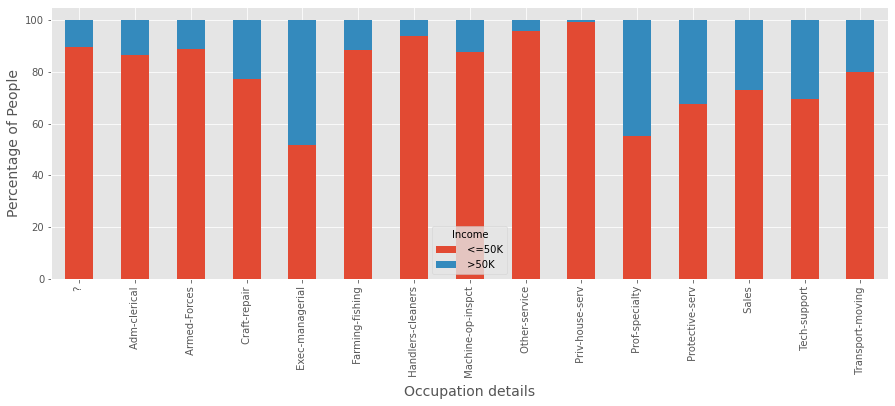

In [41]:
tbl = pd.crosstab(df['Occupation'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Occupation details',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us all the occupation informaton for the people and to earn an income of >50k the designations which helps are execute manegerial position.

Text(0, 0.5, 'Percentage of People')

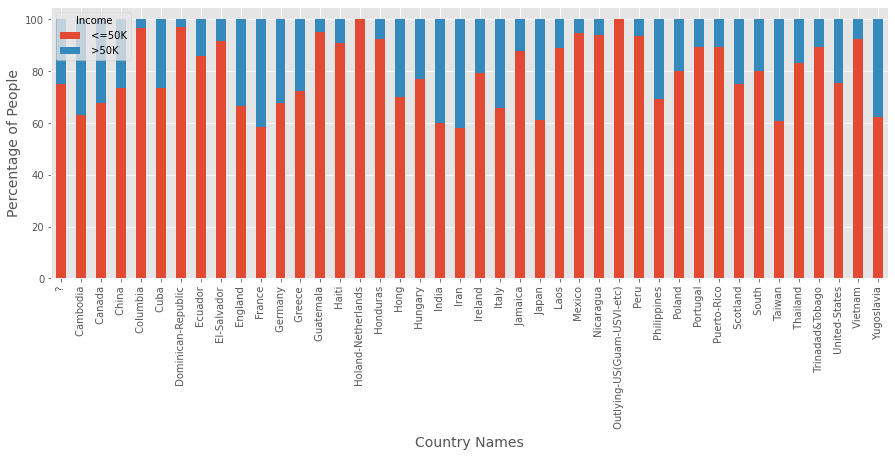

In [42]:
tbl = pd.crosstab(df['Native_country'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Country Names',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us the native place country details for people settled in the US. 

Text(0, 0.5, 'Percentage of People')

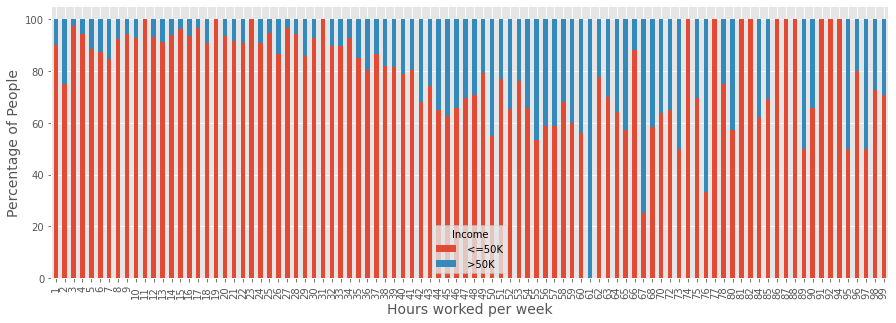

In [43]:
tbl = pd.crosstab(df['Hours_per_week'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Hours worked per week',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us that people with >=50k income mostly work 61 hours per week .

Text(0, 0.5, 'Percentage of People')

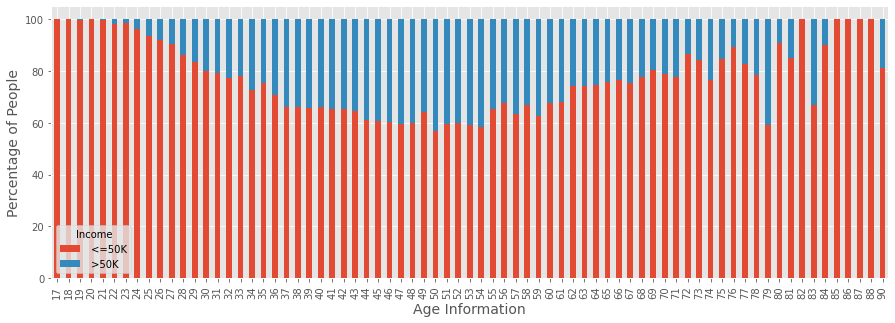

In [44]:
tbl = pd.crosstab(df['Age'],df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Age Information',fontsize=14)
plt.ylabel('Percentage of People',fontsize=14)

The above cross tab bar plot show us that younger people mostly have an income of <=50k and older people generally have an income of >=50k.

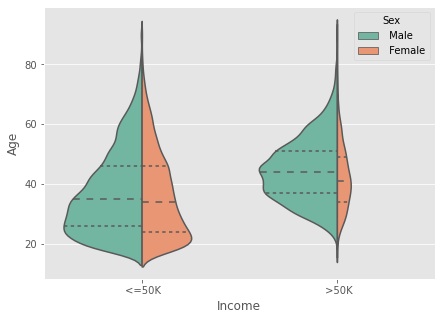

In [45]:
plt.figure(figsize=(7,5))
sns.violinplot(x="Income",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.show()

Above violin plot shows us that male any age group and income group have higher number than their female counterparts.

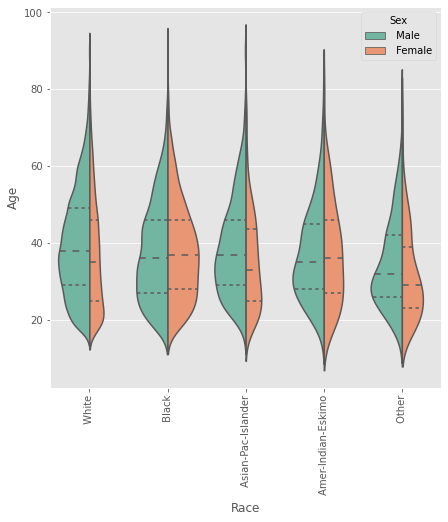

In [46]:
plt.figure(figsize=(7,7))
sns.violinplot(x="Race",y="Age",hue="Sex",data=df,
               palette="Set2",split=True,scale="count",inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that female with black ethinicity of any age group is higher than the other ethinicity group females.

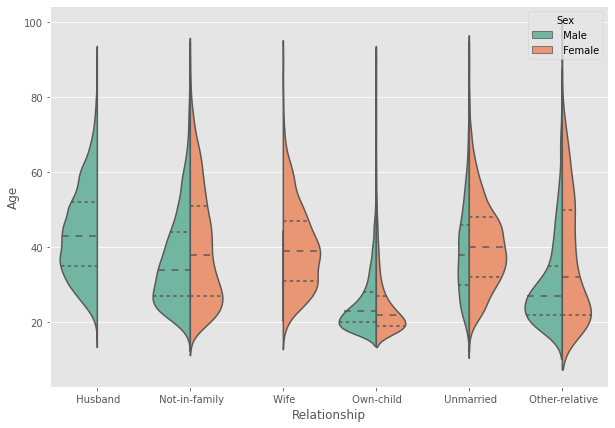

In [47]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Relationship",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.show()

Above violin plot shows us that people in the own child relationship age from 10-40 . also we have female who are unmrried more than the male counterparts.

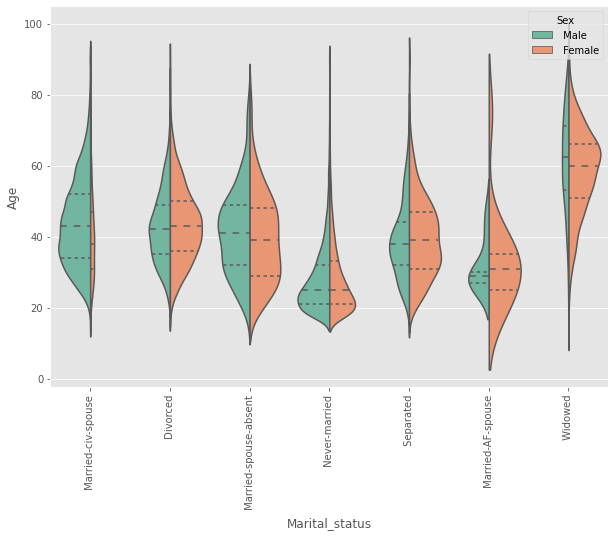

In [48]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Marital_status",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that marital status as married spouse have a higher number in male than in female and people who are widowed have ahigher number in emalesas compared to the males.

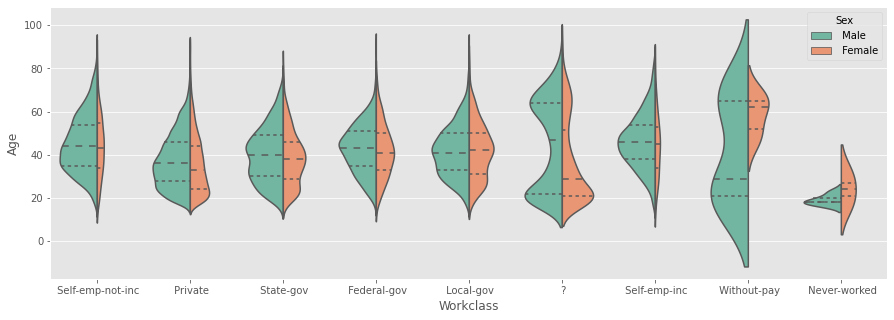

In [49]:
plt.figure(figsize=(15,5))
sns.violinplot(x="Workclass",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.show()

Above violin plot shows us that male cover most of the working class sectors in each category as compared to the females.

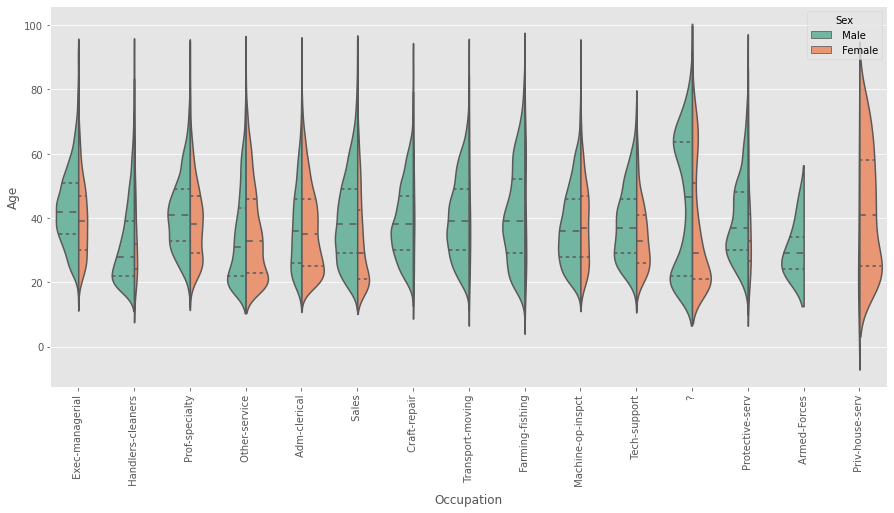

In [50]:
plt.figure(figsize=(15,7))
sns.violinplot(x="Occupation",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that the designation of theprivate house services has more numbers of female mostly from the 20-60 age group whilee occupation such as craft repair, transport moving ,farming/shifting,protective /security service and armed force have a larger humber of data.

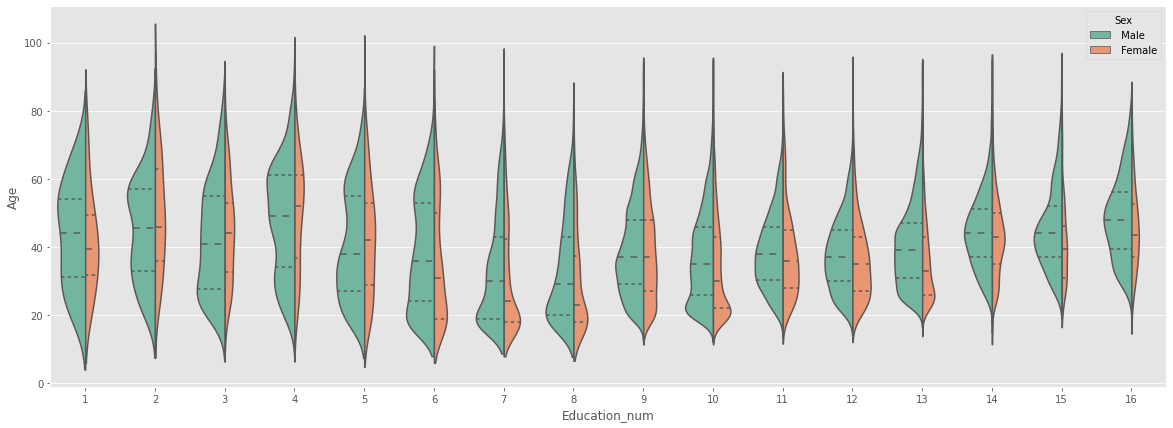

In [51]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education_num",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.show()

Above violin plot shows us that males in all age group have higher education number compared to their female counterparts.

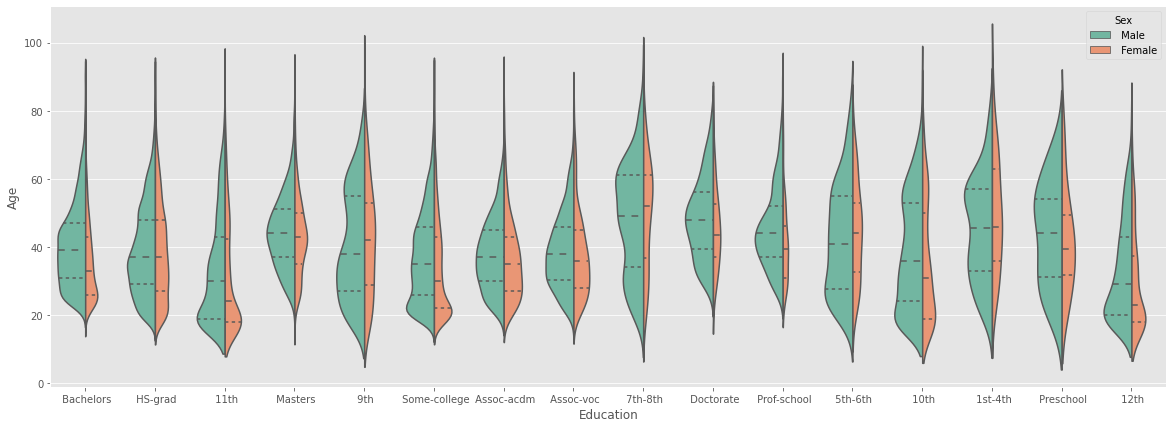

In [52]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education",y="Age",hue="Sex",data=df,
              palette="Set2",split=True,scale="count",inner="quartile")
plt.show()

Above violin plot shows us that just like the education number the education category sets more numbers of males their female counter parts giving us red flag on how female education is concern.

Encoding the  categorical object datatype columns

In [53]:
le = LabelEncoder()
df["Income"] = le.fit_transform(df["Income"])
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


U sing labelencoder to conert the columns into he numeric formart

In [54]:
oe = OrdinalEncoder()
df['Workclass'] = oe.fit_transform(df['Workclass'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Marital_status'] = oe.fit_transform(df['Marital_status'].values.reshape(-1,1))
df['Occupation'] = oe.fit_transform(df['Occupation'].values.reshape(-1,1))
df['Relationship'] = oe.fit_transform(df['Relationship'].values.reshape(-1,1))
df['Native_country'] = oe.fit_transform(df['Native_country'].values.reshape(-1,1))
df['Race'] = oe.fit_transform(df['Race'].values.reshape(-1,1))
df['Sex'] = oe.fit_transform(df['Sex'].values.reshape(-1,1))
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6.0,83311,9.0,13,2.0,4.0,0.0,4.0,1.0,0,0,13,39.0,0
1,38,4.0,215646,11.0,9,0.0,6.0,1.0,4.0,1.0,0,0,40,39.0,0
2,53,4.0,234721,1.0,7,2.0,6.0,0.0,2.0,1.0,0,0,40,39.0,0
3,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,5.0,0
4,37,4.0,284582,12.0,14,2.0,4.0,5.0,4.0,0.0,0,0,40,39.0,0


I could have used one hot encoder here but i preffered ordinal encoder to ensure that the number of columns do not get increased unnecessarily.

In [55]:
print(f"Shape of our data frame post enconding is",df.shape)
df.isnull().sum()

Shape of our data frame post enconding is (32536, 15)


Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

I am checking the numbers of rows and columns present in our dataset after applying the encoding techniques and ensuring that there are no null values presentin them.

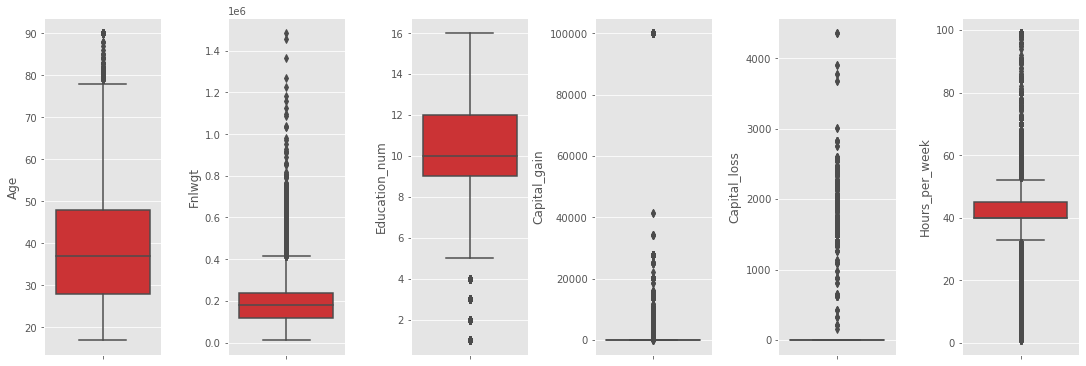

In [56]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set1")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of boxplot we can see the outliers details present in our numerical data columns which will need to be treated.

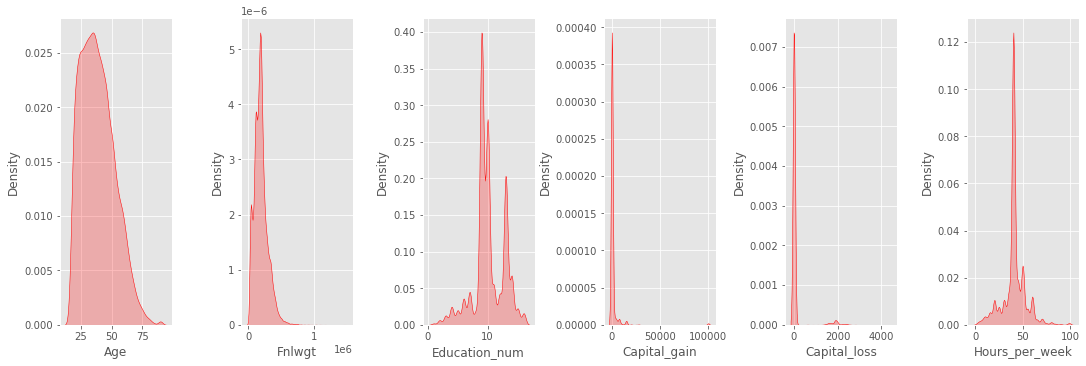

In [57]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade":True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewnessdetails present in our numerical data columns which will need to be treated

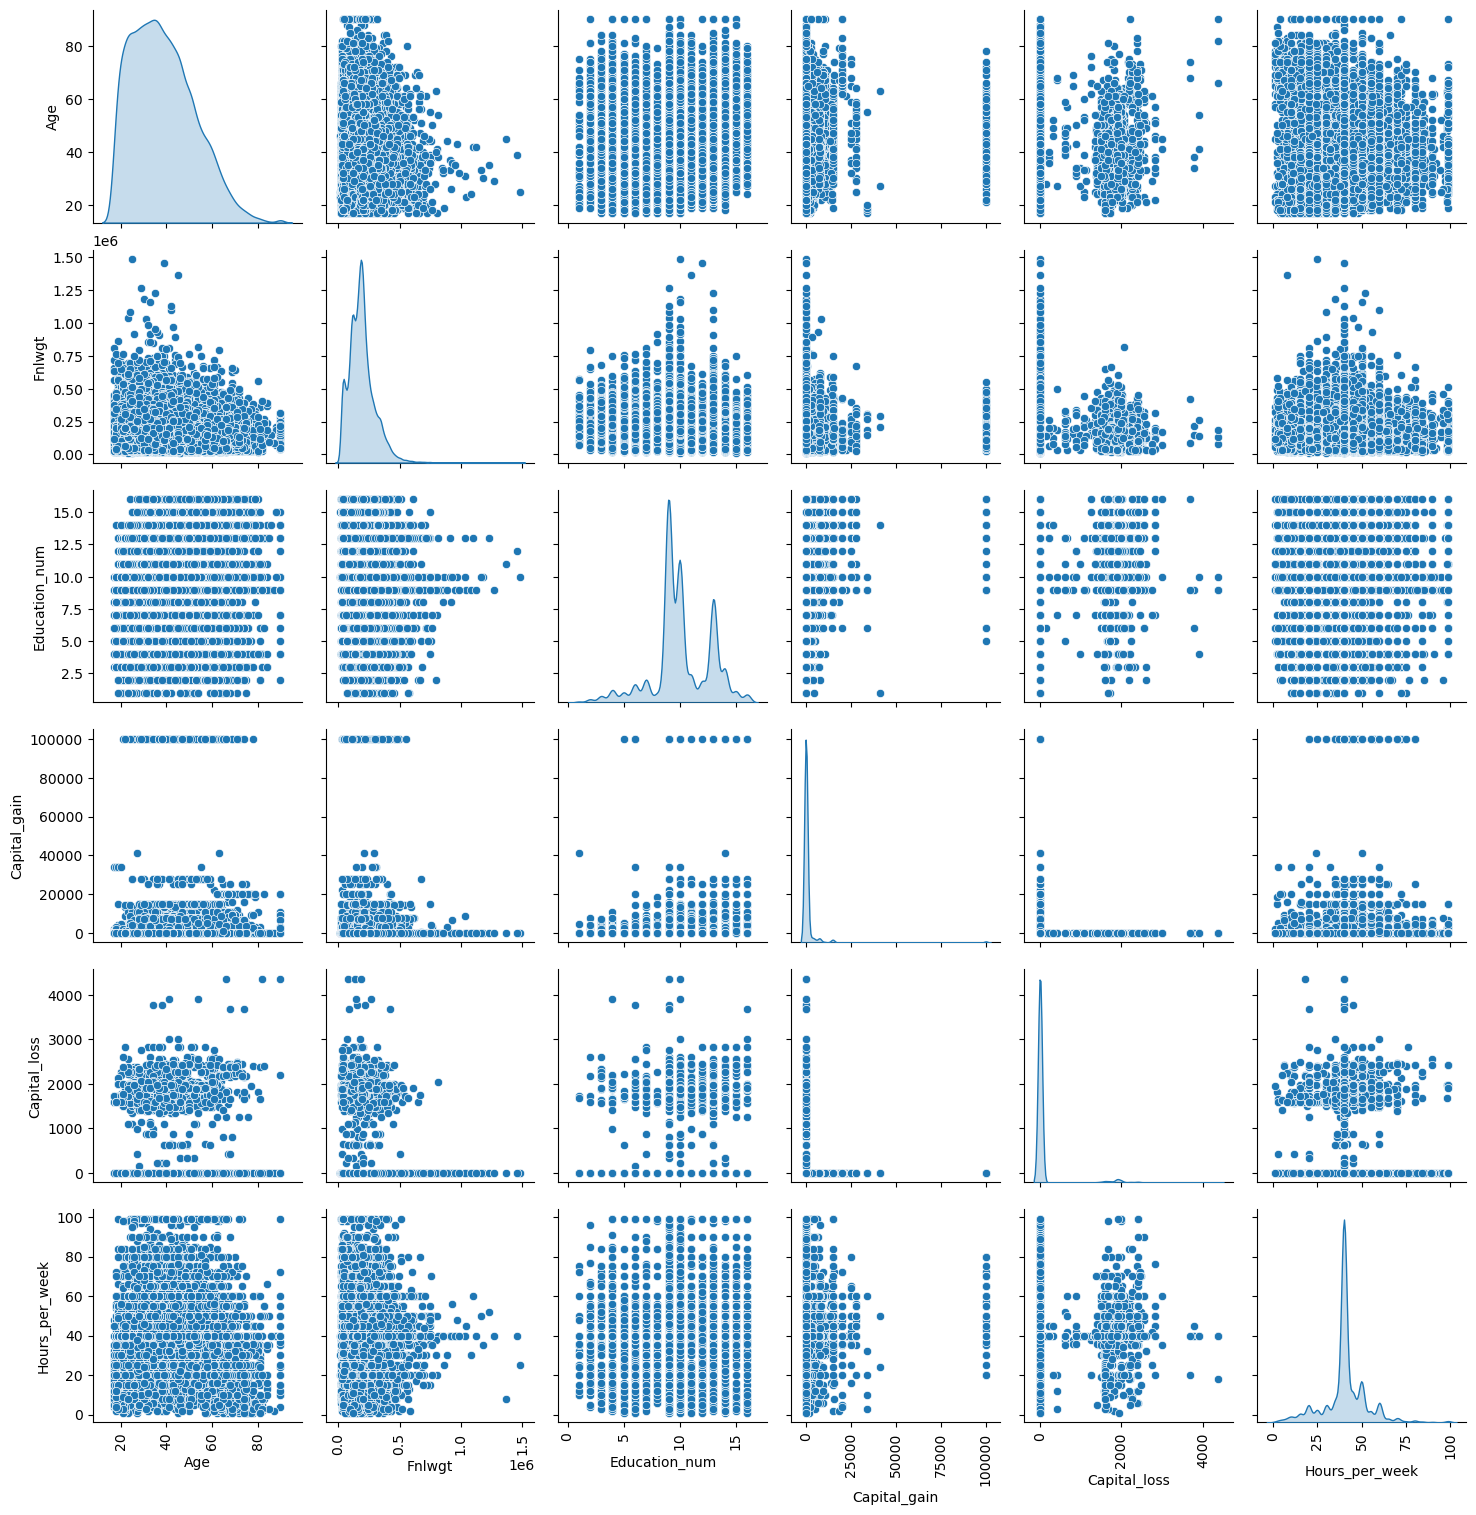

In [58]:
num_values = df.drop(['Workclass','Marital_status','Education','Occupation','Relationship','Race','Sex',
                      'Native_country','Income'],axis=1)
plt.style.use('default')
g = sns.pairplot(num_values, diag_kind="kde")
for ax in g.axes.flat:
    ax.tick_params("x",labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns and shows us how the data points are available in each of them.

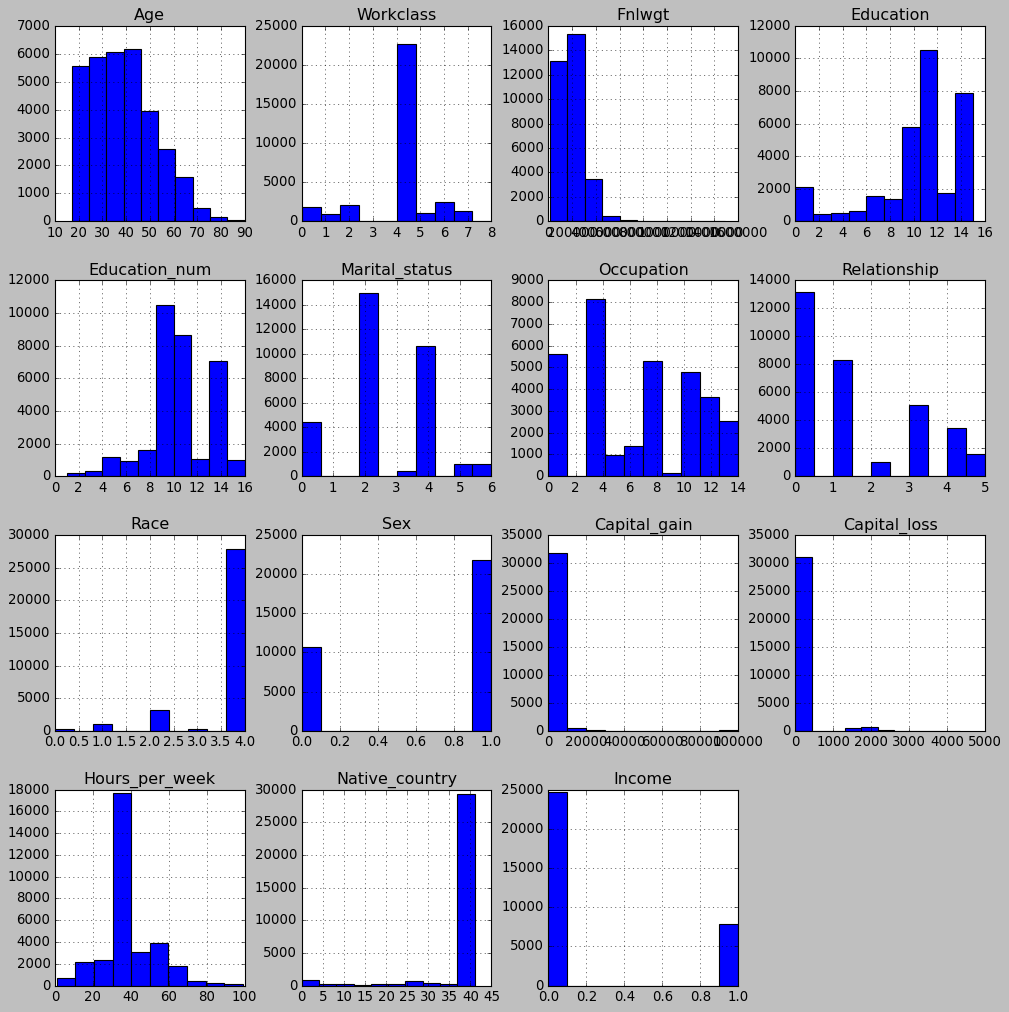

In [59]:
plt.style.use('classic')
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying encoding and converting object datatype to numeric datatype values.

Corelation using heatmap

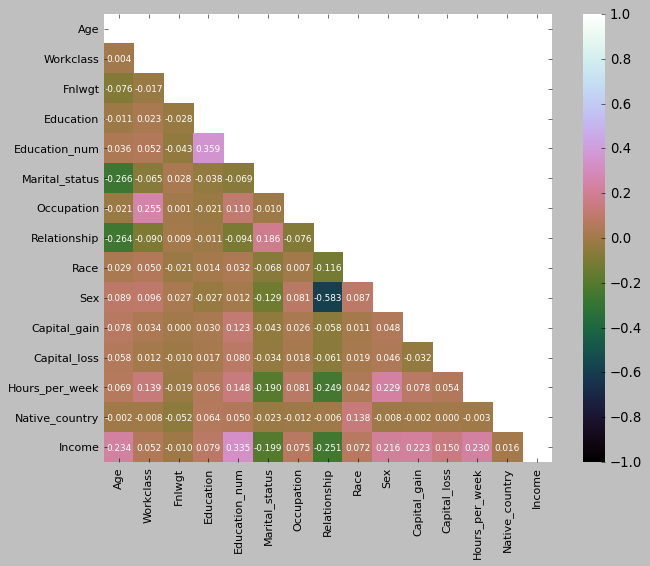

In [60]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f',
            annot_kws={'size':8}, cmap="cubehelix", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heat map we can see that correlation details plus we can determine that there is no multi colinearity issue between our columns.

Corelation bar plot comparing features with our labels

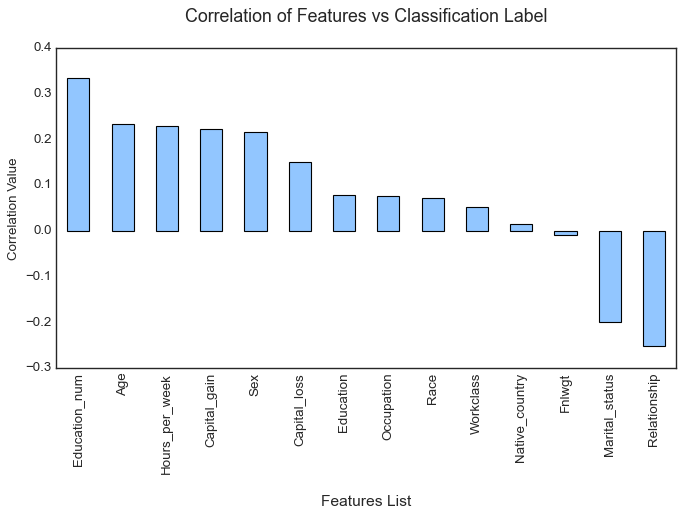

In [61]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(10,5))
df_corr['Income'].sort_values(ascending=False).drop('Income').plot.bar()
plt.title("Correlation of Features vs Classification Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since heatmap was not able to give us a clea picture on positive and negative correlation columns we have generated this bar plot and 
we can see that columns  relationship and marital status are the only ones negatively correlated rest all the other feature columns are positively correlated with our label column.

Using z SCORE technique to remove outliers

In [62]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print("Shape of the dataframe before removing outliers",df.shape)
print("Shape of the dataframe after removing outliers",df1.shape)
print("Percentage of data loss post outliers removal", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy()

Shape of the dataframe before removing outliers (32536, 15)
Shape of the dataframe after removing outliers (27399, 15)
Percentage of data loss post outliers removal 15.788664863535775


I a lossing 15.788of data i m able to afford the loss considering i have a lots of rows in our dataset to be used while model building.

In [63]:
df.skew()

Age                0.483537
Workclass         -0.737658
Fnlwgt             0.627331
Education         -0.957459
Education_num     -0.143317
Marital_status    -0.043793
Occupation         0.130948
Relationship       0.749953
Race              -2.592371
Sex               -0.684100
Capital_gain       4.933077
Capital_loss      29.316076
Hours_per_week    -0.357277
Native_country    -5.466051
Income             1.324408
dtype: float64

its acceptable range of +/-5 value.

USING log transform to fix skewness

In [64]:
for col in integer_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

i applied log transform to remove skewness of our dataset.

In [65]:
df.skew()

Age                0.483537
Workclass         -0.737658
Fnlwgt            -0.955214
Education         -0.957459
Education_num     -0.143317
Marital_status    -0.043793
Occupation         0.130948
Relationship       0.749953
Race              -2.592371
Sex               -0.684100
Capital_gain       3.111491
Capital_loss      24.838742
Hours_per_week    -0.357277
Native_country    -5.466051
Income             1.324408
dtype: float64

we have manged to remove the skewness from our numerical columns.

Splitting the dataset into 2 variables

In [66]:
X = df.drop('Income', axis=1)
Y = df['Income']

X represent the feature column and Y represent the target column.

In [67]:
Y.value_counts()

0    21263
1     6136
Name: Income, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category.

In [68]:
oversample = SMOTE()
X,Y = oversample.fit_resample(X,Y)

In [69]:
Y.value_counts()

0    21263
1    21263
Name: Income, dtype: int64

Feature scaling

In [70]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
0,0.774521,1.536070,-1.138001,-0.429606,1.019601,-0.318798,-0.654770,-0.729761,0.307861,0.608339,-0.386857,-0.032746,-2.648285,0.174900
1,-0.174249,0.065428,0.525431,0.136823,-0.629804,-1.849137,-0.175488,-0.106009,0.307861,0.608339,-0.386857,-0.032746,-0.145671,0.174900
2,1.011713,0.065428,0.673678,-2.695320,-1.454506,-0.318798,-0.175488,-0.729761,-3.481720,0.608339,-0.386857,-0.032746,-0.145671,0.174900
3,-0.253314,0.065428,1.010585,0.420037,1.431952,-0.318798,-0.654770,2.389001,0.307861,-1.690623,-0.386857,-0.032746,-0.145671,0.174900
4,0.695457,0.065428,0.005448,-1.279249,-2.279208,0.446371,0.303795,-0.106009,-3.481720,-1.690623,-0.386857,-0.032746,-2.370216,-6.203334


I am scaling my feature data to ensure that tere is no issue with the data biasness over a particular period.

Finding best random state for building classification models

In [71]:
maxAccu=0
maxRS=0

for i in range(1,1000):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=i)
    lr = LogisticRegression()
    lr.fit(X_train,Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test,pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i
        
print("Best accuracy score is",maxAccu,"on Random State",maxRS)

Best accuracy score is 77.8122648607976 on Random State 814


we have found 498 amongst 1-1000 range

,Importance
Features,
Relationship,0.153
Marital_status,0.152
Age,0.147
Fnlwgt,0.122
Occupation,0.072
Education_num,0.070
Hours_per_week,0.068
Capital_gain,0.064
Education,0.049


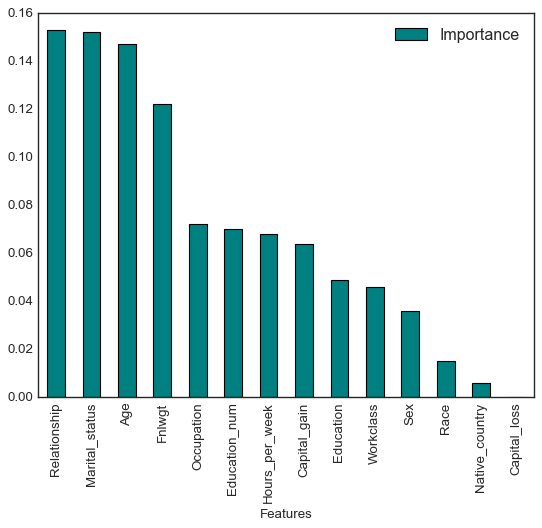

In [72]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
importances = pd.DataFrame({'Features':X.columns,'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

with the help of randomforestclassifier we are able to list down the importance or priority given to a column as per its involvement.

MACHINE LEARNING MODEL FOR CLAASSIFICATION WITH EVALUTION MATRICS

In [73]:
def classify(model,X,Y):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=498)
    
    model.fit(X_train,Y_train)
    
    pred = model.predict(X_test)
    
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n",class_report)
    
    acc_score = (accuracy_score(Y_test,pred))*100
    print("Accuracy Score:",acc_score)
    
    cv_score = (cross_val_score(model,X,Y,cv=5).mean())*100
    print("Cross Validation Score:",cv_score)
    
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is",result)

I have defined the class with the help of train test split ,training of machine learning model.

In [74]:
#Logistic Regression

model=LogisticRegression()
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      5311
           1       0.76      0.78      0.77      5321

    accuracy                           0.77     10632
   macro avg       0.77      0.77      0.77     10632
weighted avg       0.77      0.77      0.77     10632

Accuracy Score: 76.85289691497367
Cross Validation Score: 76.59080832798732

Accuracy Score - Cross Validation Score is 0.2620885869863514


In [75]:
#support vector classifier

model=SVC(C=1.0,kernel='rbf',gamma='auto',random_state=42)
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      5311
           1       0.81      0.90      0.85      5321

    accuracy                           0.85     10632
   macro avg       0.85      0.85      0.84     10632
weighted avg       0.85      0.85      0.84     10632

Accuracy Score: 84.51843491346878
Cross Validation Score: 83.86404534033659

Accuracy Score - Cross Validation Score is 0.6543895731321925


In [76]:
#DecisionTreeClassifier


model=DecisionTreeClassifier(random_state=21,max_depth=15)
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      5311
           1       0.83      0.91      0.87      5321

    accuracy                           0.87     10632
   macro avg       0.87      0.87      0.87     10632
weighted avg       0.87      0.87      0.87     10632

Accuracy Score: 86.53122648607976
Cross Validation Score: 85.87467683703022

Accuracy Score - Cross Validation Score is 0.6565496490495377


In [77]:
#RandomForestClassifier


model=RandomForestClassifier(max_depth=15,random_state=111)
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      5311
           1       0.86      0.93      0.89      5321

    accuracy                           0.89     10632
   macro avg       0.89      0.89      0.89     10632
weighted avg       0.89      0.89      0.89     10632

Accuracy Score: 88.68510158013544
Cross Validation Score: 88.01218630055791

Accuracy Score - Cross Validation Score is 0.6729152795775235


In [78]:
#KNeighborsClassifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      5311
           1       0.81      0.89      0.85      5321

    accuracy                           0.84     10632
   macro avg       0.84      0.84      0.84     10632
weighted avg       0.84      0.84      0.84     10632

Accuracy Score: 83.93528969149736
Cross Validation Score: 83.69002590832932

Accuracy Score - Cross Validation Score is 0.24526378316804198


In [79]:
#ExtraTreesClassifier
model=ExtraTreesClassifier()
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      5311
           1       0.89      0.92      0.91      5321

    accuracy                           0.90     10632
   macro avg       0.91      0.90      0.90     10632
weighted avg       0.91      0.90      0.90     10632

Accuracy Score: 90.46275395033861
Cross Validation Score: 90.31194994217175

Accuracy Score - Cross Validation Score is 0.15080400816685824


In [80]:
#XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      5311
           1       0.89      0.91      0.90      5321

    accuracy                           0.90     10632
   macro avg       0.90      0.90      0.90     10632
weighted avg       0.90      0.90      0.90     10632

Accuracy Score: 89.69149736644093
Cross Validation Score: 88.88704518565793

Accuracy Score - Cross Validation Score is 0.8044521807830023


HYPER PARAMETER TUNING ON THE BEST CLASSIFICATION ML MODEL

In [81]:
fmod_param = {'criterion' : ['gini', 'entropy'],
             'n_jobs':[-2, -1, 1],
             'random_state':[42, 498, 1000],
             'max_depth':[0, 15, 30],
             'n_estimators':[100, 200, 300] 
             }

After comparing all the classifiaction model i have selected to extra trees classifier as my best model considering the accuracy score with the cross validation score against it

In [82]:
GSCV = GridSearchCV(ExtraTreesClassifier(),fmod_param,cv=5)

In [83]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 498, 1000]})

I have trained the grid search cv with the list of parameters i feel it should come best possible outcomes

In [84]:
GSCV.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'n_estimators': 300,
 'n_jobs': -2,
 'random_state': 498}

here provides the best parameters

In [85]:
Final_Model = ExtraTreesClassifier(criterion='entropy',max_depth=15,n_estimators=100,n_jobs=-2,random_state=42)
Classifier = Final_Model.fit(X_train,Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test,fmod_pred))*100
print("Accuracy score for the Best Model is:",fmod_acc)

Accuracy score for the Best Model is: 85.53423626787058


I have sucessfully incorporated the hyper parameter turning on my final model and received the accuracy score for it. 

AOC ROC Curve

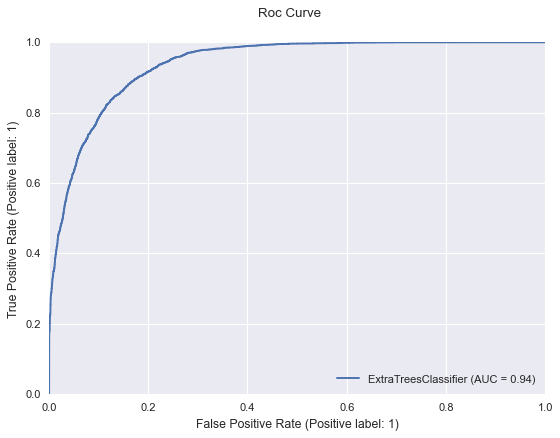

In [86]:
plt.style.use('seaborn')
disp=metrics.plot_roc_curve(Final_Model,X_test,Y_test)
disp.figure_.suptitle("Roc Curve")
plt.show()

I have generated the roc curve for my final model and its shows the auc score for my model to be 94%

CONFUSION MATRIX

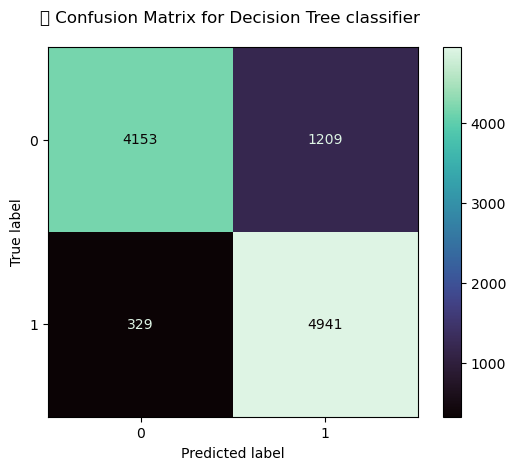

In [87]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier,X_test,Y_test,cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree classifier \n')
plt.show()

With the help of confusion matrix i am able to understand the numbers of times i got the correct outputs .

Saving the model

In [88]:
filename = "FinalModel_E05.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_E05.pkl']

Finally i saving my best classification model by using joblib